# About timeline_viz.ipynb

This notebook uses the functions defined and demontrasted in *utils_timeline_viz.ipynb* to clean log data and visualize it. You will find here:
* How to viz one student's activity
* How to print several viz
* Examples


In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages

## Quick demo on 1 student

In [2]:
%aimport utils_timeline_viz
studentid = '90447168'
parsed_file = find_student_log_file("beers",studentid)
df = prep_parsing_data(parsed_file)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


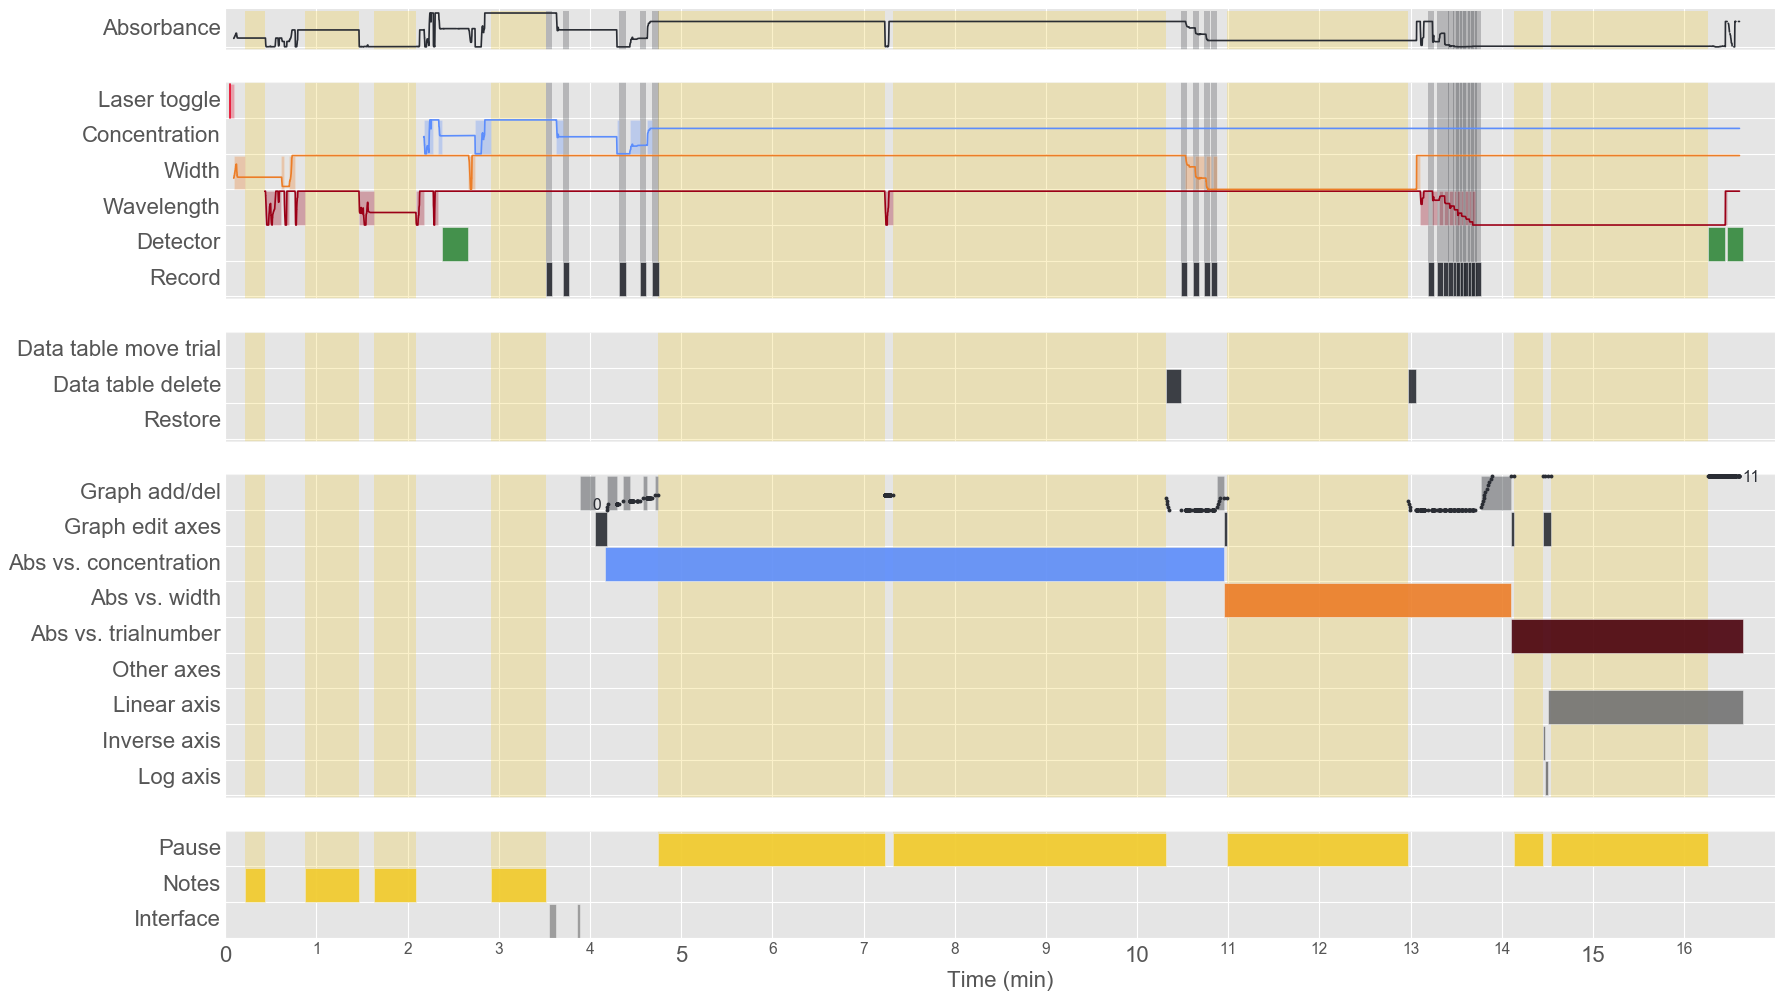

In [3]:
%aimport utils_timeline_viz
plot(df,to_plot_beers,family_name_to_code,function_to_use,colors)

## For publication

In [4]:
%aimport utils_timeline_viz
def plot_publication(df,to_plot,family_name_to_code,function_to_use,colors):
    ax = plt.subplot()
    spacing = 10
    margin = 0.5
    component_spacer = spacing
    n_spacer = 0
    max_time = 17*60 #max 17 min long

    for i,action in enumerate(to_plot):
        alpha = 0.9
        color = colors[action]
        if action == '':
            alpha = 1
            color = 'white'
            action_use = [(0,max_time)]
        elif action  == 'Graph add/del':
            values,coords,confounded,action_use = function_to_use[action](df,action)
            if len(values)>0:
                min_v,max_v = 0.0,max(values)
                #plot legend                
                ax.text(coords[0]-10,i*spacing,'0',horizontalalignment='left',fontsize=14, color=colors[action])
                ax.text(coords[-1]+2,(i+1)*spacing-2,str(max_v),horizontalalignment='left',fontsize=14, color=colors[action])
                #Add "0 points" in the values and coords
                coords.insert(0,coords[0])
                values.insert(0,0)
                norm_values = [(v-min_v)/(max_v-min_v)*(spacing-margin) +i*spacing for v in values] #normalize so it fits in x_axis
                ax.plot(coords,norm_values,'-',color=color, linewidth=1.5,alpha=1)


        elif action in ['Absorbance','Wavelength','Width','Concentration','Laser toggle',
                        'Battery voltage','Separation','Area','Charge']:
            #get time coords for changes in that variable, and the values of those changes
            values,coords,action_use = function_to_use[action](df,action)
            if action == 'Laser toggle':#values for the laser toggle are actually the previous value before action so we need to fix up the values a bit
                values,coords = fix_laser(values,coords)
            # elif action == 'Connection':
            #     if np.nan == values[0]: #when no udpate states in log
            #         values,coords = fix_connection(values,coords)
            elif len(values)>0:
                #add last value ended sim with
                values.append(values[-1])
                coords.append(df['Time'].iloc[-1])
            min_v,max_v = MIN_MAX[action]
            norm_values = [(v-min_v)/(max_v-min_v)*(spacing-margin) +i*spacing for v in values] #normalize so it fits in x_axis
            ax.plot(coords,norm_values,'-',color=color,linewidth=1.5,alpha=1)
            if action == 'Charge' or action == 'Battery voltage': #show baseline around 0 to see when values are pos or negative
                ax.plot(coords,[(0-min_v)/(max_v-min_v)*(spacing-margin) +i*spacing for v in values],'-',color='white',linewidth=1.5,alpha=0.8)
            alpha = 0.3
        elif action in function_to_use.keys():
            action_use = function_to_use[action](df)   
        else:
            action_use = action_usage(df,'Family',family_name_to_code[action])
            action_use = clean_coords(action_use)
        if "vs. Concentration" in action:
            color = colors['Concentration']
        elif "vs. Width" in action:
            color = colors['Width']
        if action_use:
            if action in ['Pause','Notes']:
                a = 0.25
                ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=color,linewidth=0,edgecolor='k',alpha=a)
            elif action == 'Record':
                a = 0.25
#                 ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=color,linewidth=0,edgecolor='k',alpha=a)
            elif action == 'Lightbulb connected' or action == 'Graph add/del':
                alpha = 0.4
            height = (i*spacing+(n_spacer)*component_spacer,(component_spacer))
            ax.broken_barh(action_use,height,facecolors=color,alpha=alpha)#,linewidth=0,edgecolor='k')

    #Shape plot
    ax.set_ylim(0, len(to_plot)*spacing+1)
    ax.set_xlim(0, max_time)
    
    #Add labels
    ax.set_xlabel('Time (min)',fontsize=20)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=20)
    ax.set_xticks(range(0,int(max_time),60), minor=True)
    ax.set_xticklabels([str(x/60)+''if x not in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=14, minor=True)
    ax.set_yticks(range(0,len(to_plot)*spacing,spacing)) #for the grid
    ax.set_yticklabels(['' for p in to_plot])
    ax.set_yticks(range(spacing/2,len(to_plot)*spacing,spacing),minor=True) #minor ticks
    def fix_name(track):
        d = {'Abs vs. TrialNumber':'A vs. $\lambda$','Abs vs. Width':'A vs. w','Abs vs. Concentration':'A vs. c'}
        if track in d.keys():
            return d[track]#+"           "
        else: return track#+"           "
    to_plot = [fix_name(track) for track in to_plot]
    ax.set_yticklabels([a.capitalize() for a in to_plot],fontsize=20, minor=True)
    ax.grid(True)
    
    # ax2 = ax.twiny()
    # ax2.set_xlim(0, max_time)
    # ax2.set_xlabel('',fontsize=20)
    # ax2.set_xticks(range(0,int(max_time),60))
    # ax2.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    # ax2.grid(False)

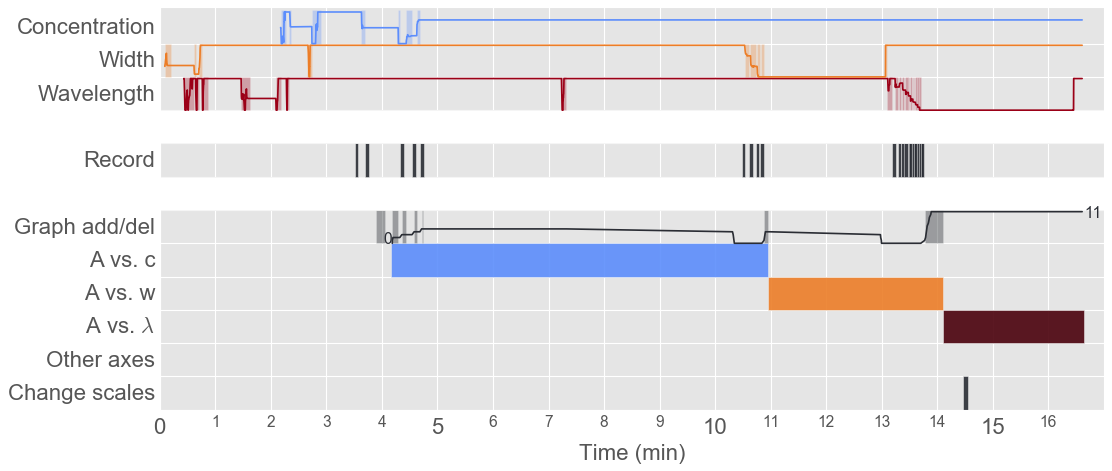

In [5]:
matplotlib.rcParams['figure.figsize'] = 14, 6
to_plot_publication_beers = ['Change scales','Other axes','Abs vs. TrialNumber','Abs vs. Width','Abs vs. Concentration','Graph add/del','','Record','','Wavelength','Width','Concentration']
plot_publication(df,to_plot_publication_beers,family_name_to_code,function_to_use,colors)
plt.tight_layout()
plt.savefig("studentB.svg")

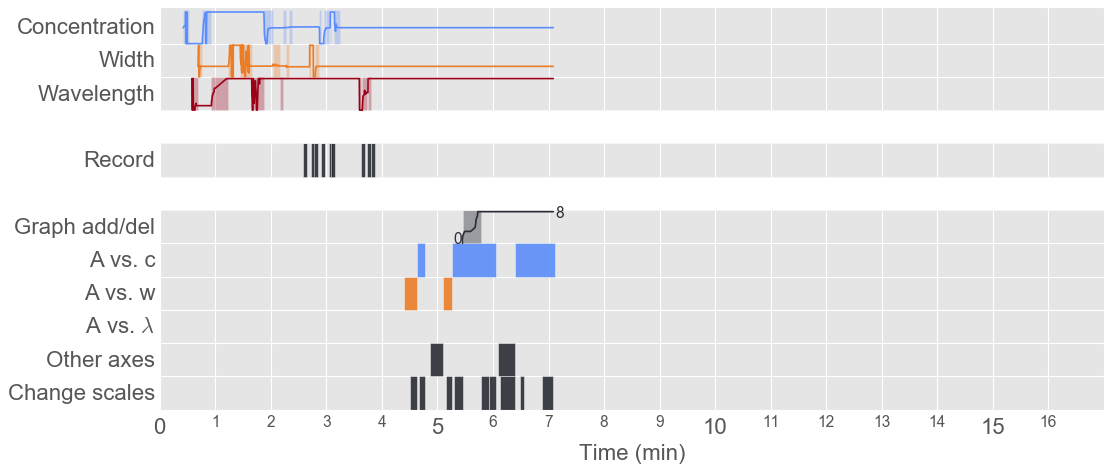

In [6]:
studentid = '12263156'; sim = 'beers'
plot_publication(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot_publication_beers,family_name_to_code,function_to_use,colors)
plt.tight_layout()
plt.savefig("studentA.svg")

## Printing multiple viz

In [7]:
matplotlib.rcParams['figure.figsize'] = 25, 15

In [8]:
name={"12302161":"Carl","19018165":"Dora","14261165":"Estelle"}
def save_multipage_viz(studentids):
    sim_name = {"beers":"Light absorbance",'capacitor':'Charge'}
    with PdfPages('multipage_timeline_viz_{0}.pdf'.format('_'.join(studentids))) as pdf:
        for sim,to_plot in [('beers',to_plot_beers),('capacitor',to_plot_caps)]:
            for studentid in studentids:
                filename = find_student_log_file(sim,studentid)
                date = date = re.search(r'\d{7,8}_([\d\-\.\_]+)\.txt', filename).group(1)
                df = prep_parsing_data(filename)
                plt.figure(figsize=(20,12))
                plt.title("{1} \t {0} \t {2}".format(name[studentid],sim_name[sim],date),fontsize=25)
                plot(df,to_plot,family_name_to_code,function_to_use,colors)
                plt.tight_layout()
                pdf.savefig()
                plt.close()

In [9]:
%aimport utils_timeline_viz
# save_multipage_viz(["90447168","12263156","17597160","17931169","19089138"])
# save_multipage_viz(["14261165","19436162","10908162"])
save_multipage_viz(["12302161","19018165","14261165"])

## Examples of different behaviors/strategies

### Inverse axis with separation

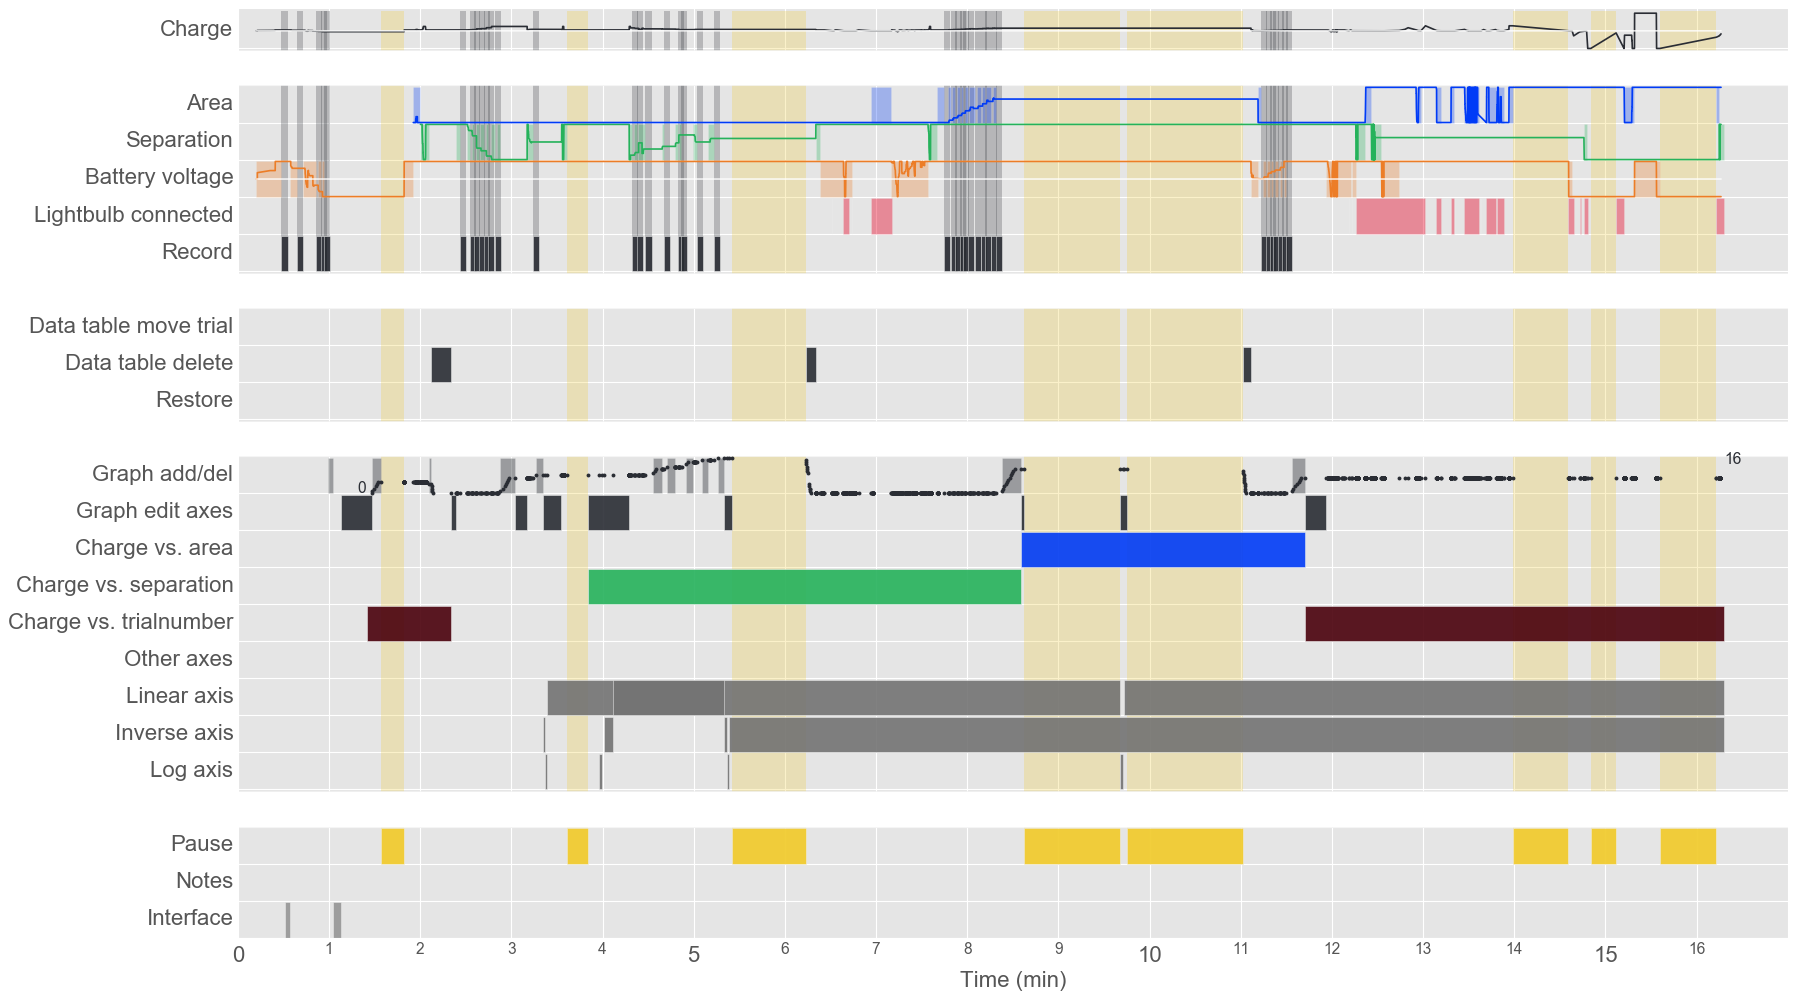

In [10]:
studentid = '19436162'; sim = 'capacitor'; to_plot = to_plot_caps
plot(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot,family_name_to_code,function_to_use,colors)

### CVS with generalization using graph

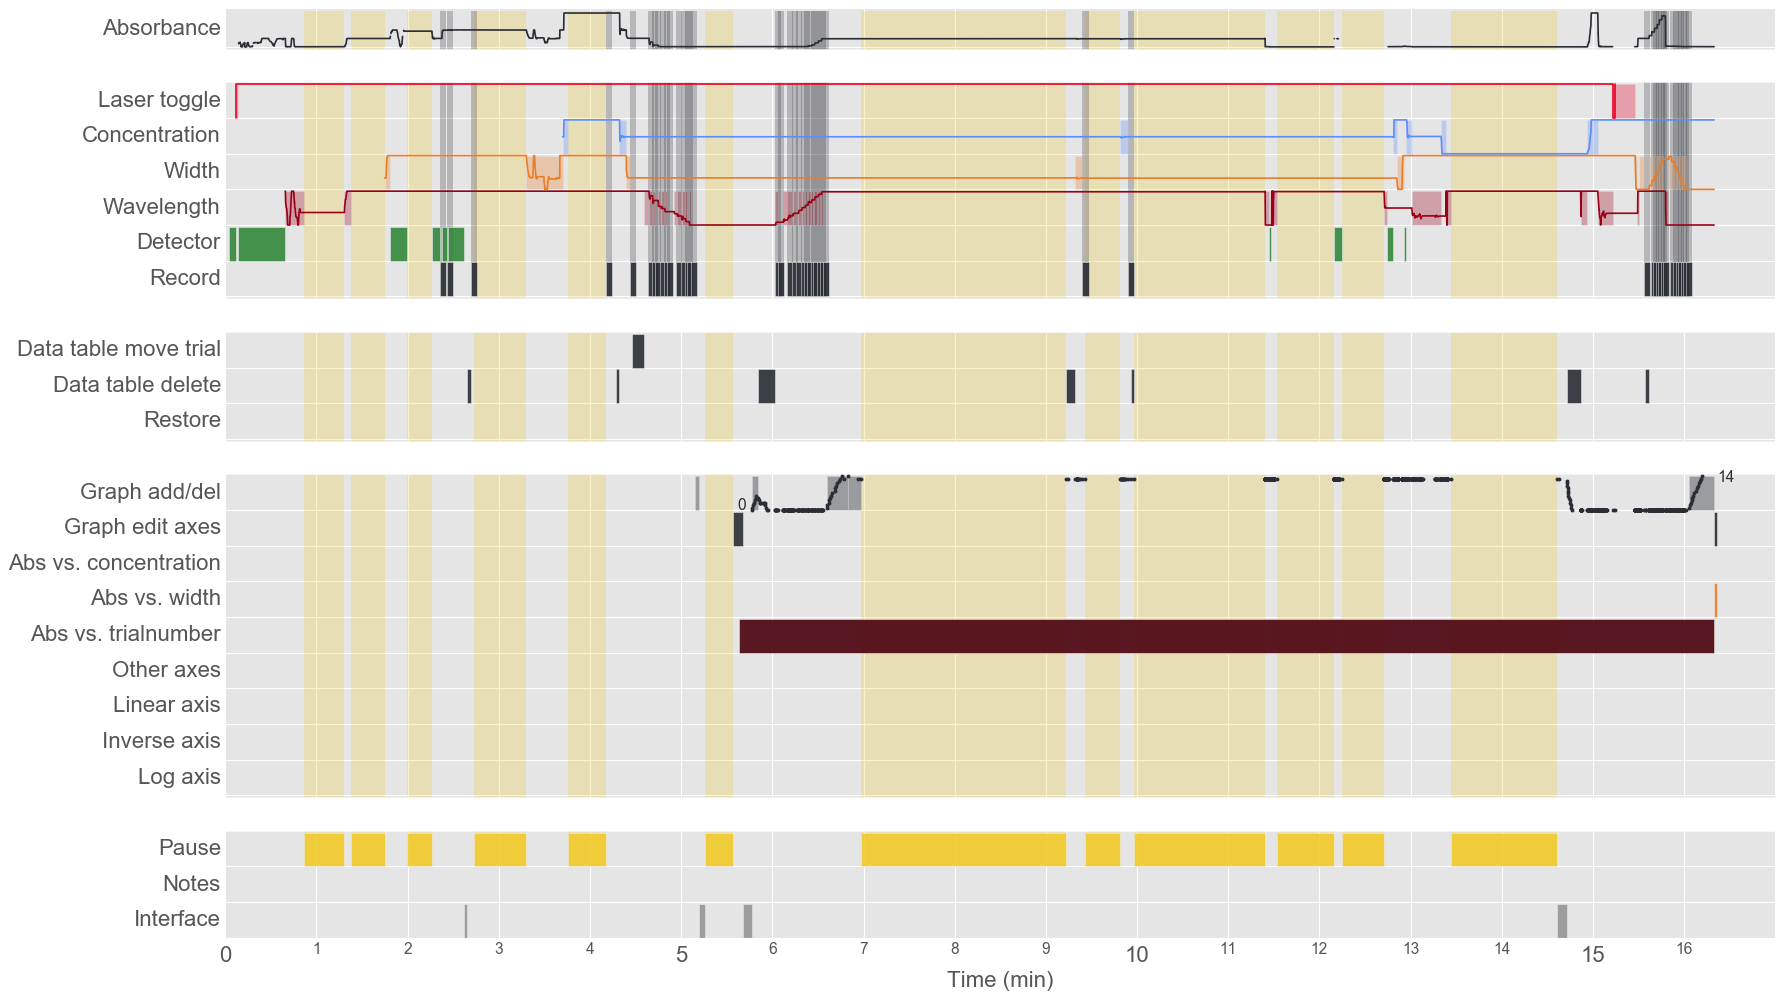

In [11]:
studentid = '14261165'; sim = 'beers'; to_plot = to_plot_beers
plot(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot,family_name_to_code,function_to_use,colors)

### Investigation of detector

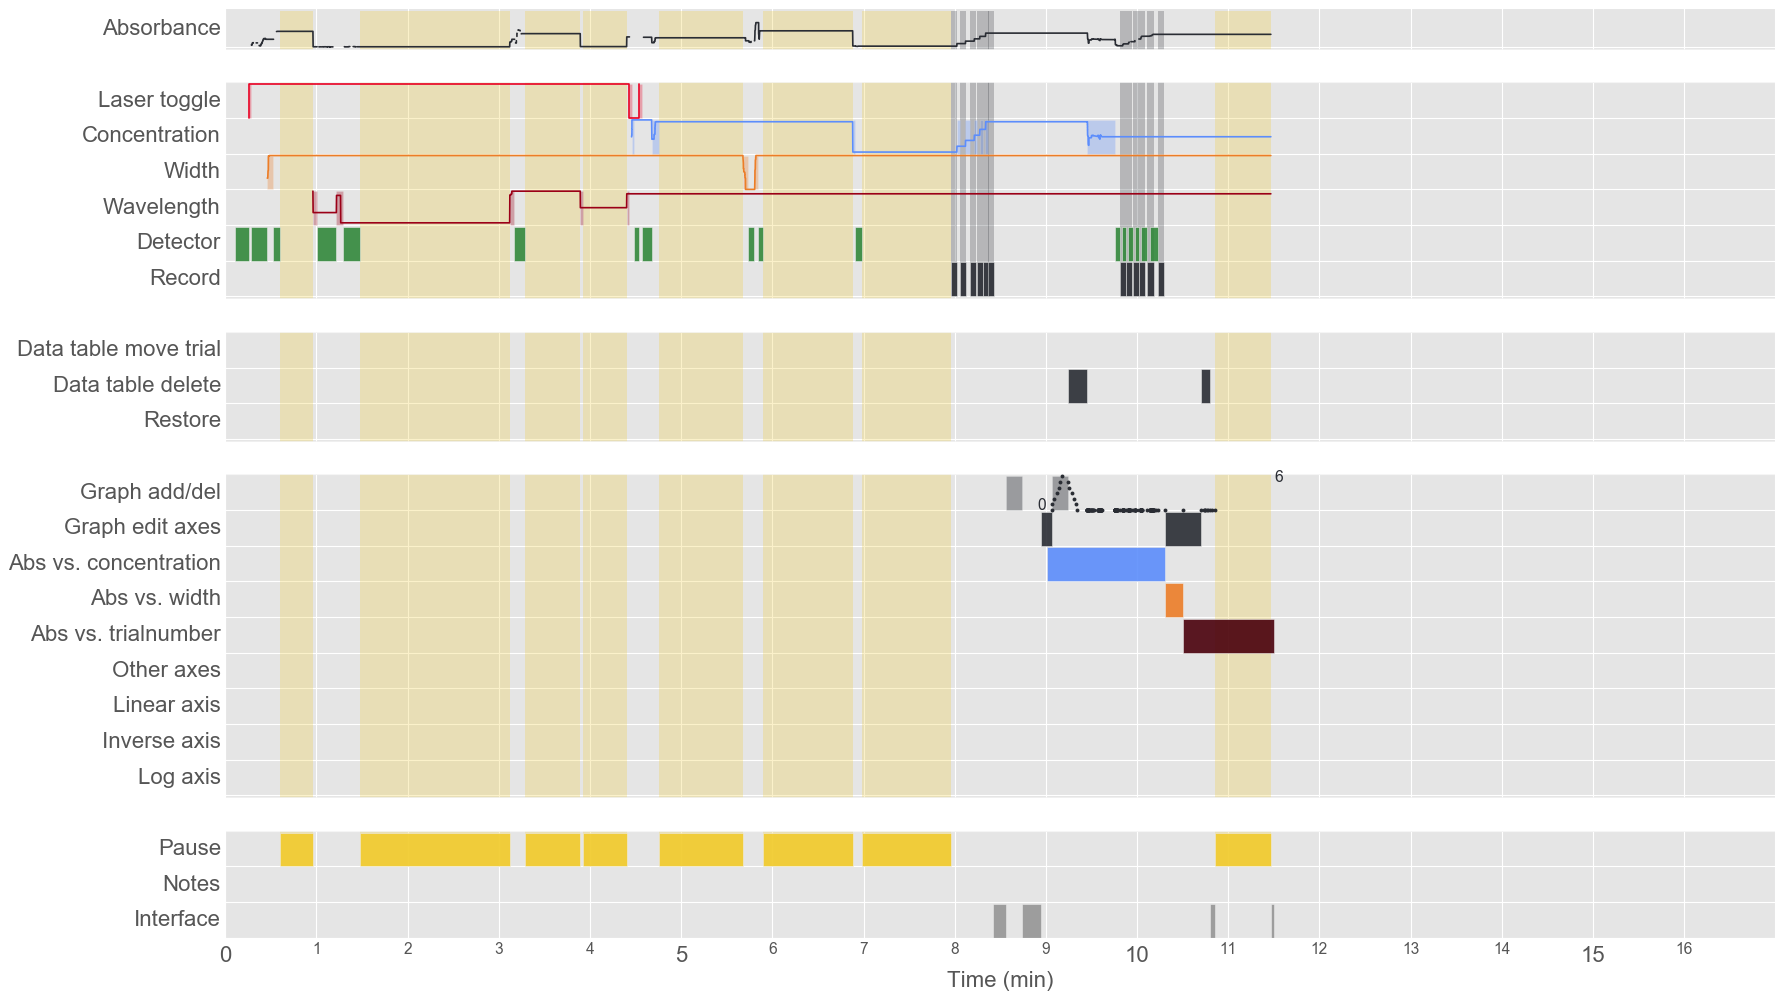

In [12]:
studentid = '10908162'; sim = 'beers'; to_plot = to_plot_beers
plot(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot,family_name_to_code,function_to_use,colors)

### Purely qualitative exploration

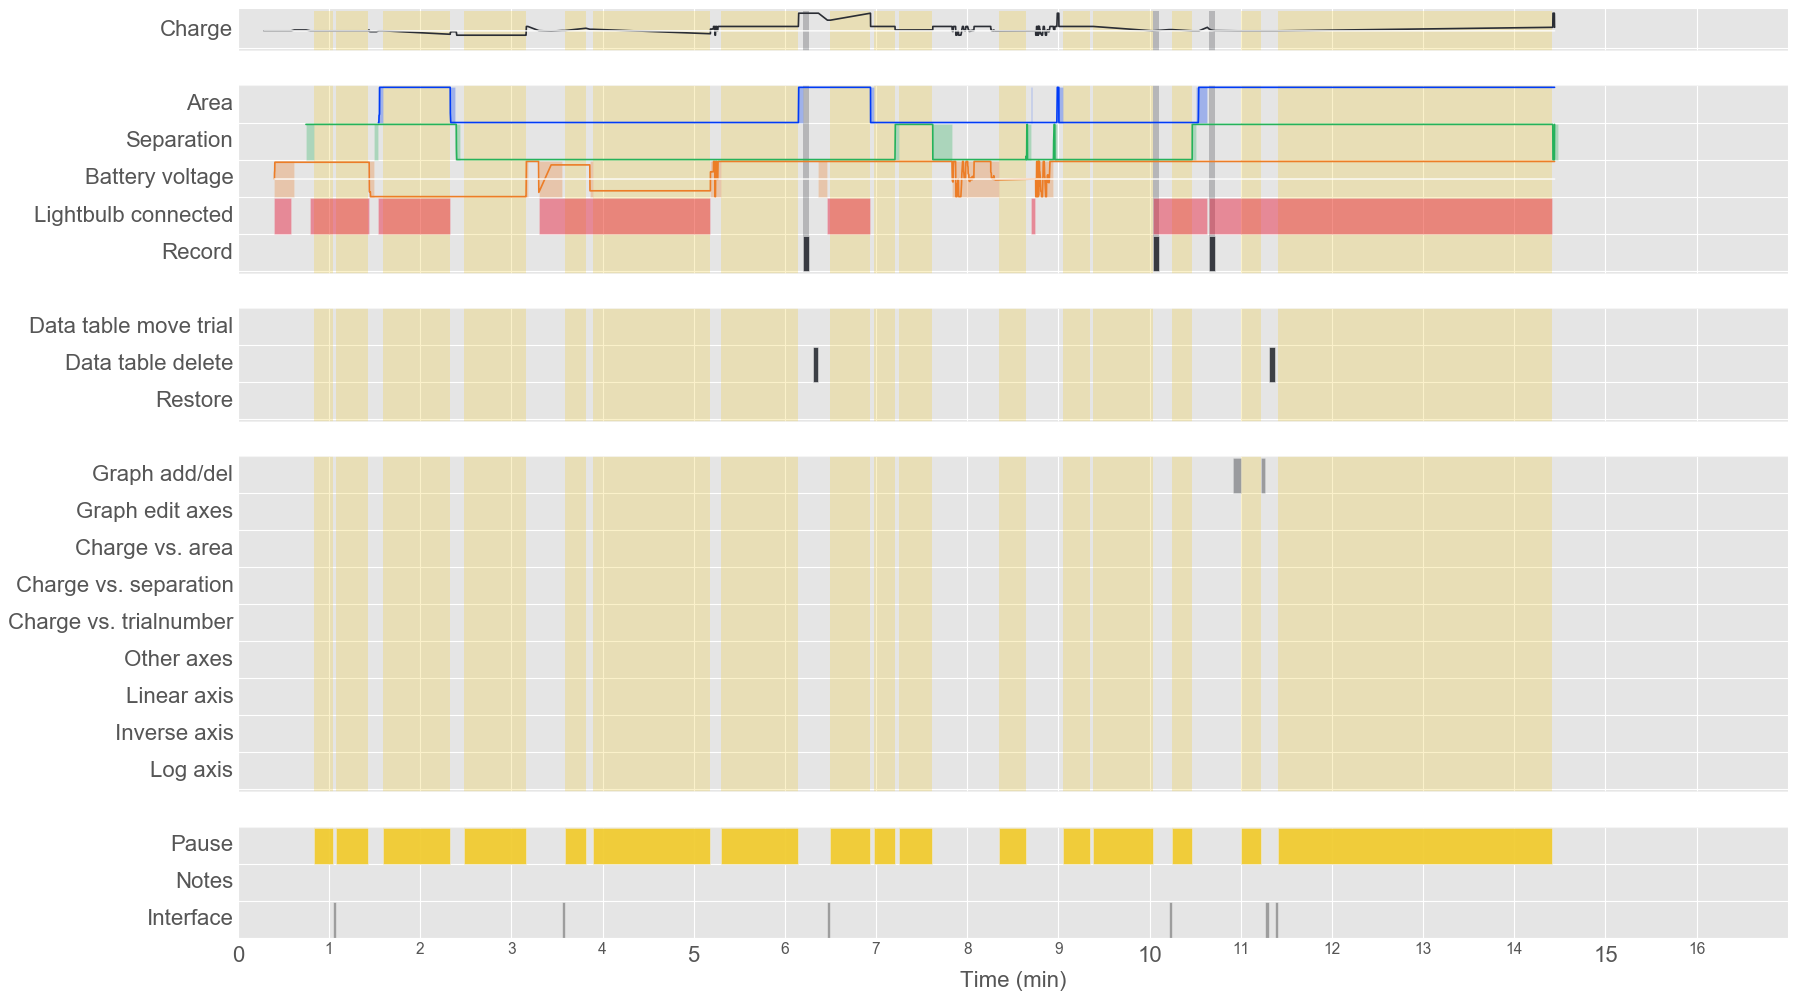

In [13]:
studentid = '17655165'; sim = 'capacitor'; to_plot = to_plot_caps
plot(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot,family_name_to_code,function_to_use,colors)

### Unproductive graph usage

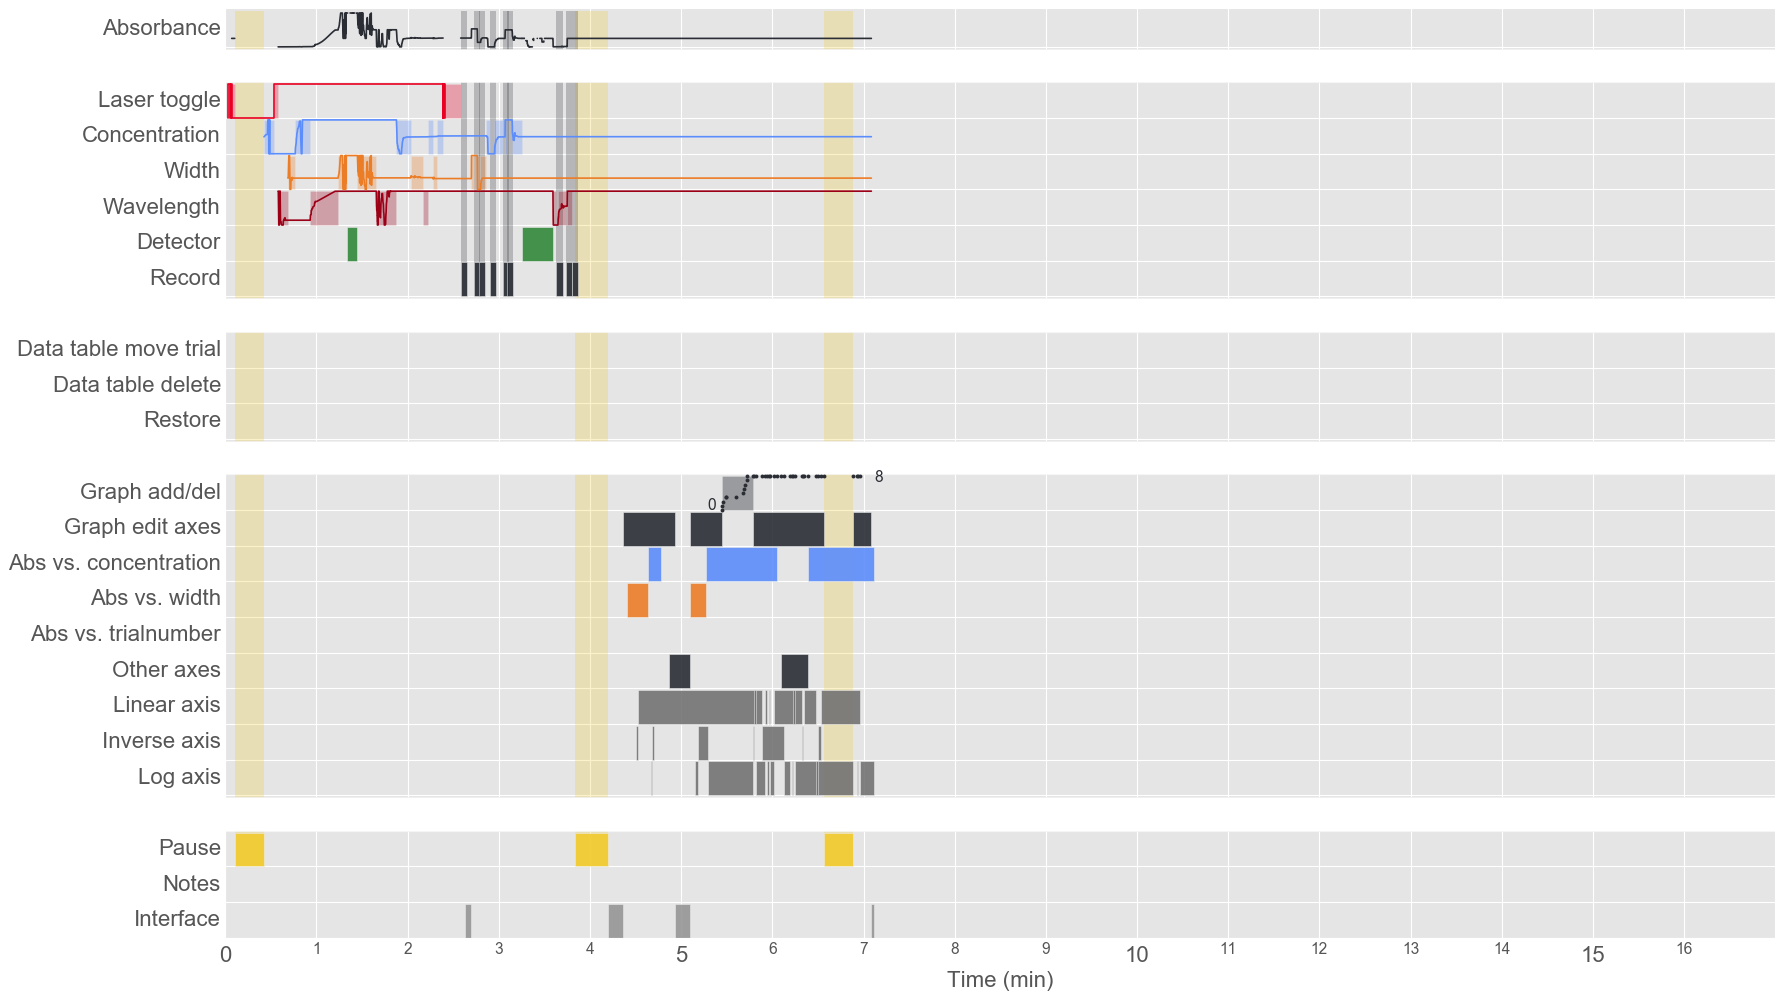

In [14]:
studentid = '12263156'; sim = 'beers'; to_plot = to_plot_beers
plot(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot,family_name_to_code,function_to_use,colors)

### Systematic: qual exploration, then cvs then plotting + pause

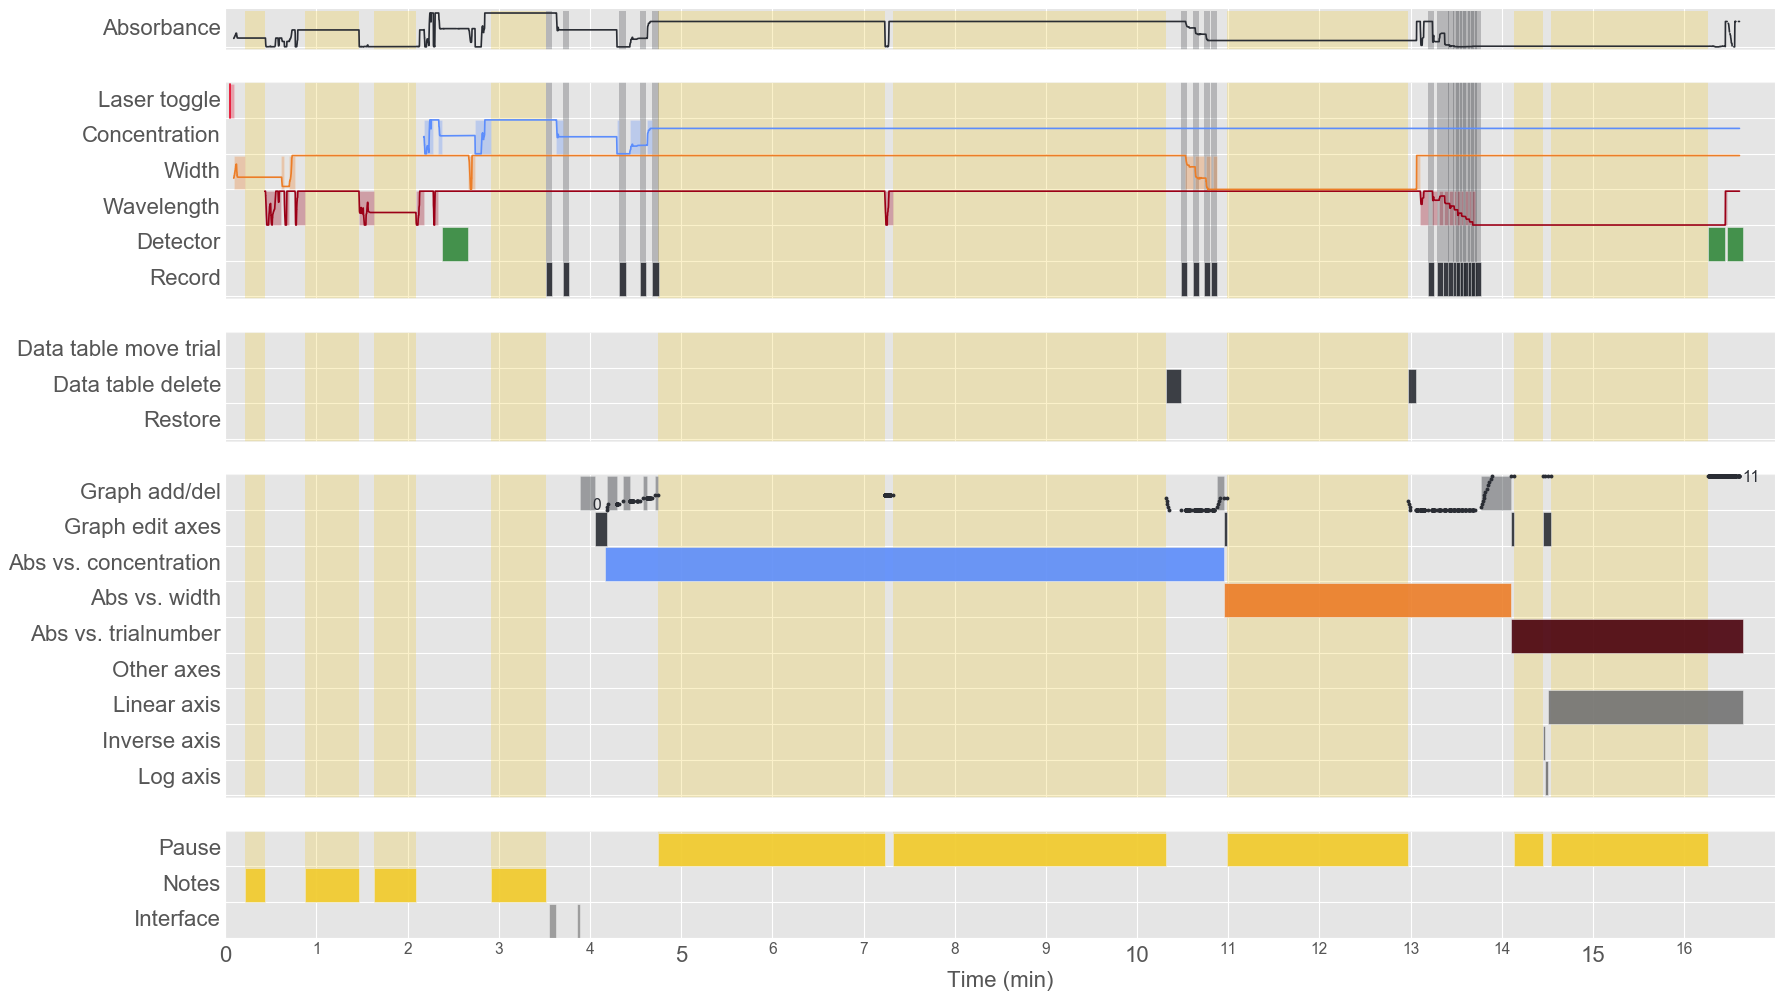

In [15]:
studentid = '90447168'; sim = 'beers'; to_plot = to_plot_beers
plot(prep_parsing_data(find_student_log_file(sim,studentid)),to_plot,family_name_to_code,function_to_use,colors)